In [85]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import corner

# Munging

First let's get the data out and into tabular form.

In [9]:
df = pd.read_csv('d_and_d_sci.txt')
df.head()

Unnamed: 0  cha  con  dex  int  str  wis   result
0           0   12    8   11   11   17   16  succeed
1           1   14   13   19   17   15   12  succeed
2           2   12   20   14    7   12   12     fail
3           3   11   14    7    9    8   19  succeed
4           4   14   16    8   15    5   17  succeed

[1 1 0 ... 0 1 1]


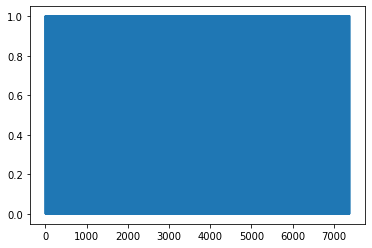

In [27]:
results = np.array([0 if r == "fail" else (1 if r == "succeed" else -1) for r in df.result])
plt.plot(results)
print(results)

I've plotted out the results just to sanity check that all results are parsing correctly. 

More data-munging to convert stuff into numpy format, which will be easier to use.

In [28]:
stats = df.to_numpy()[:,1:-1]
print(stats.shape)
print(stats[0,:])

(7387, 6)
[12 8 11 11 17 16]


In [36]:
fail_idxs = np.where(results == 0)[0]
succ_idxs = np.where(results == 1)[0]
stat_labels = ["Cha", "Con", "Dex", "Int", "Str", "Wis"]
print(fail_idxs)

[   2    7    9 ... 7375 7383 7384]


# Preliminary Visualizations

Step 1 of any data analysis is to look at the data, to the best of your ability. What does the distribution of each statistic look like?

(array([[ 118.,  349.,  620.,  963.,  676., 1555., 1219.,  961.,  623.,
          303.],
        [ 130.,  365.,  645., 1021.,  657., 1470., 1242.,  965.,  625.,
          267.],
        [ 119.,  342.,  692., 1059.,  632., 1460., 1166.,  963.,  665.,
          289.],
        [ 142.,  340.,  628.,  967.,  632., 1465., 1310.,  963.,  645.,
          295.],
        [ 104.,  341.,  630., 1017.,  652., 1444., 1267.,  971.,  661.,
          300.],
        [ 136.,  335.,  655., 1023.,  685., 1431., 1229., 1012.,  591.,
          290.]]),
 array([ 2. ,  3.8,  5.6,  7.4,  9.2, 11. , 12.8, 14.6, 16.4, 18.2, 20. ]),
 <a list of 6 BarContainer objects>)

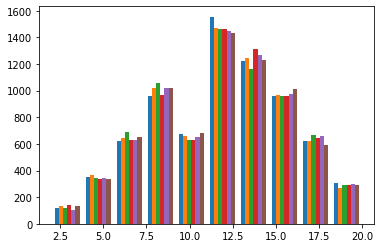

In [121]:
plt.hist([df.cha, df.int, df.wis, df.dex, df.con, df.str])

Okay, so all of these stats are distributed roughly the same way. Kind of interesting that stats of 10 are under-represented in this dataset. Are there two populations in here, one with high stats and one with low stats? Let's look at pairwise stats:

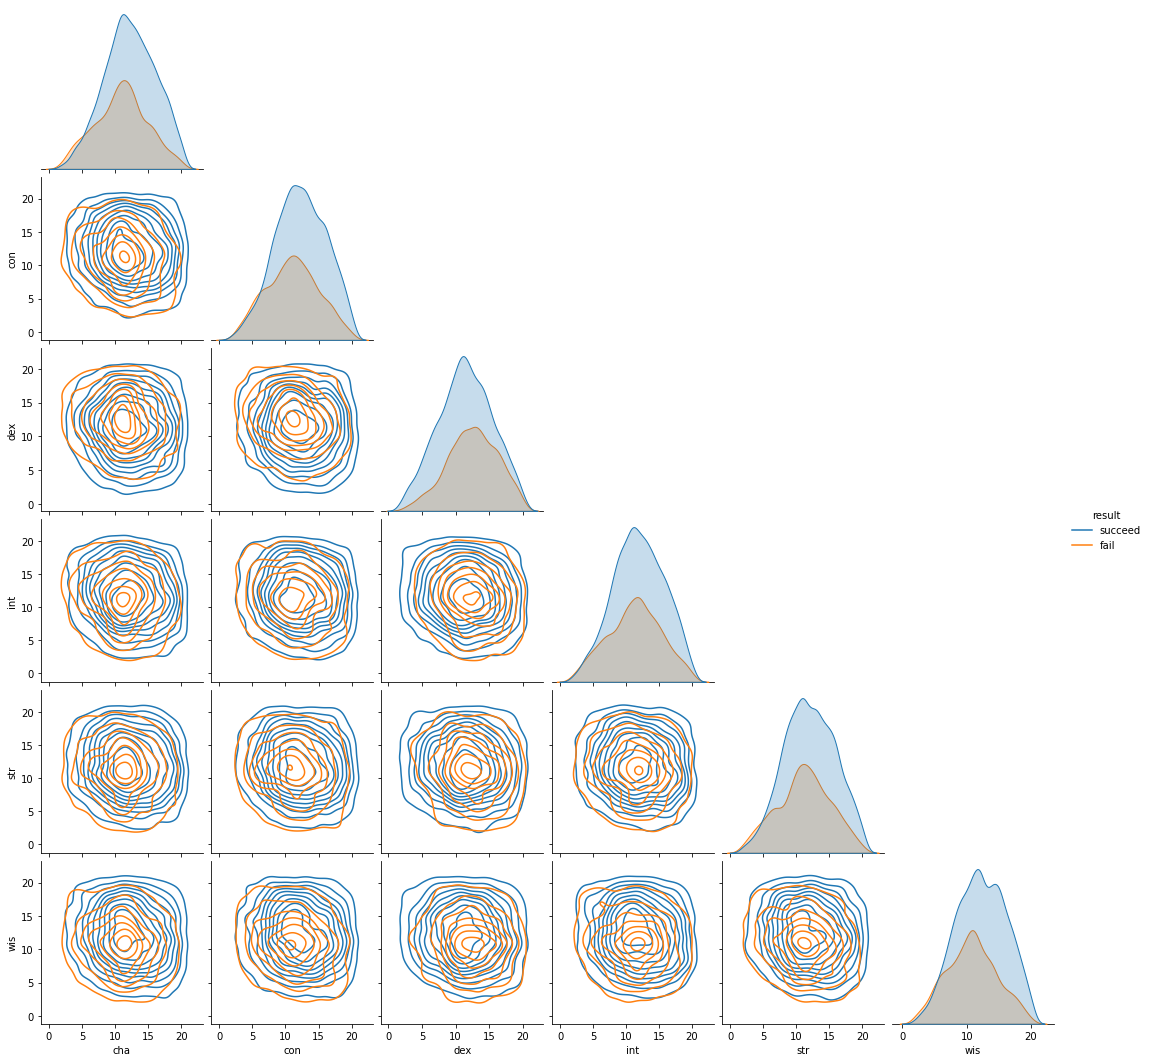

In [122]:
include_cols = ["cha", "con", "dex", "int", "str", "wis"]
g = sns.pairplot(df, hue = "result", x_vars = include_cols, y_vars = include_cols, kind = "kde", corner = True)

It doesn't look like there's a lot of correlation between stats. I'm willing to believe at this point that each statistic is independent of the others. This is really important, because I (probably) don't have to worry about confounders -- there isn't some underlying statistic that actually drives success, but also affects a bunch of scores, a sort of G-factor for RPG stats.

...but do stats have any kind of combinatorial effect? A quick way to look for this might be to look at the same thing as above, but split between only successful people and only failed people. Here are similar plots, with successful people in the first, and failures in the second. 

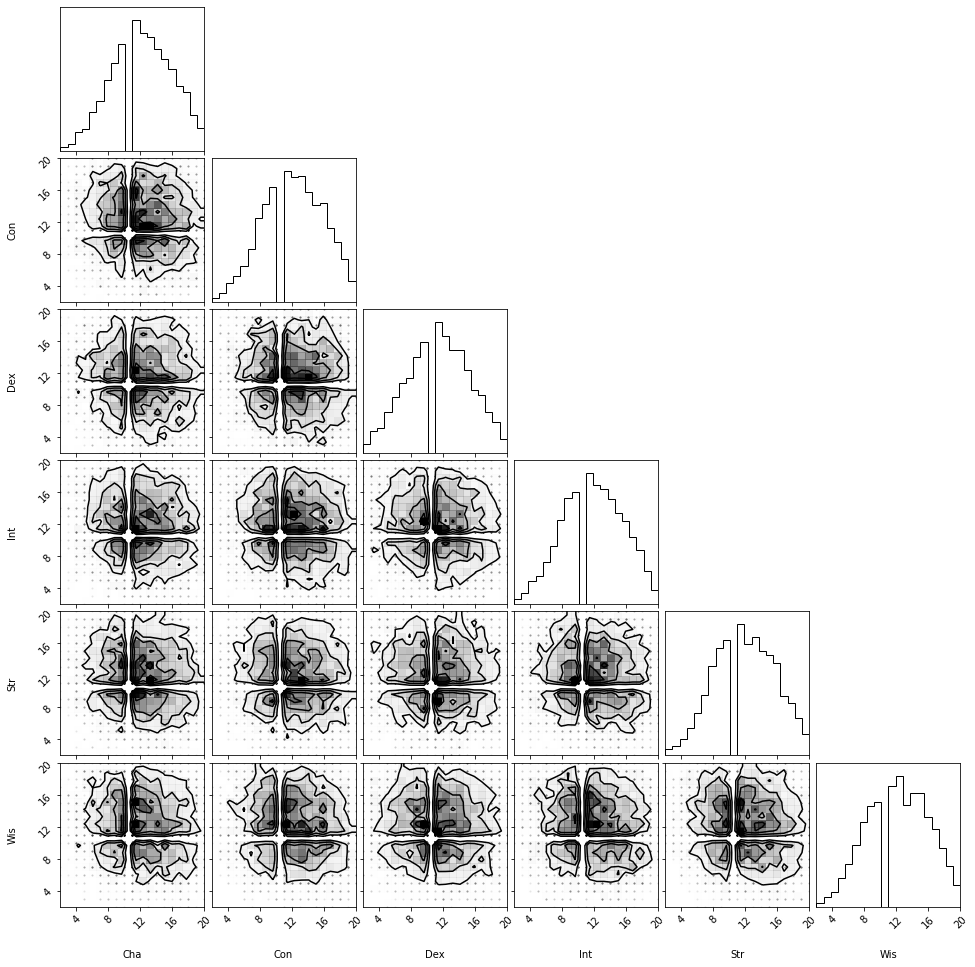

In [123]:
corner.corner(stats[succ_idxs,:], labels = stat_labels);

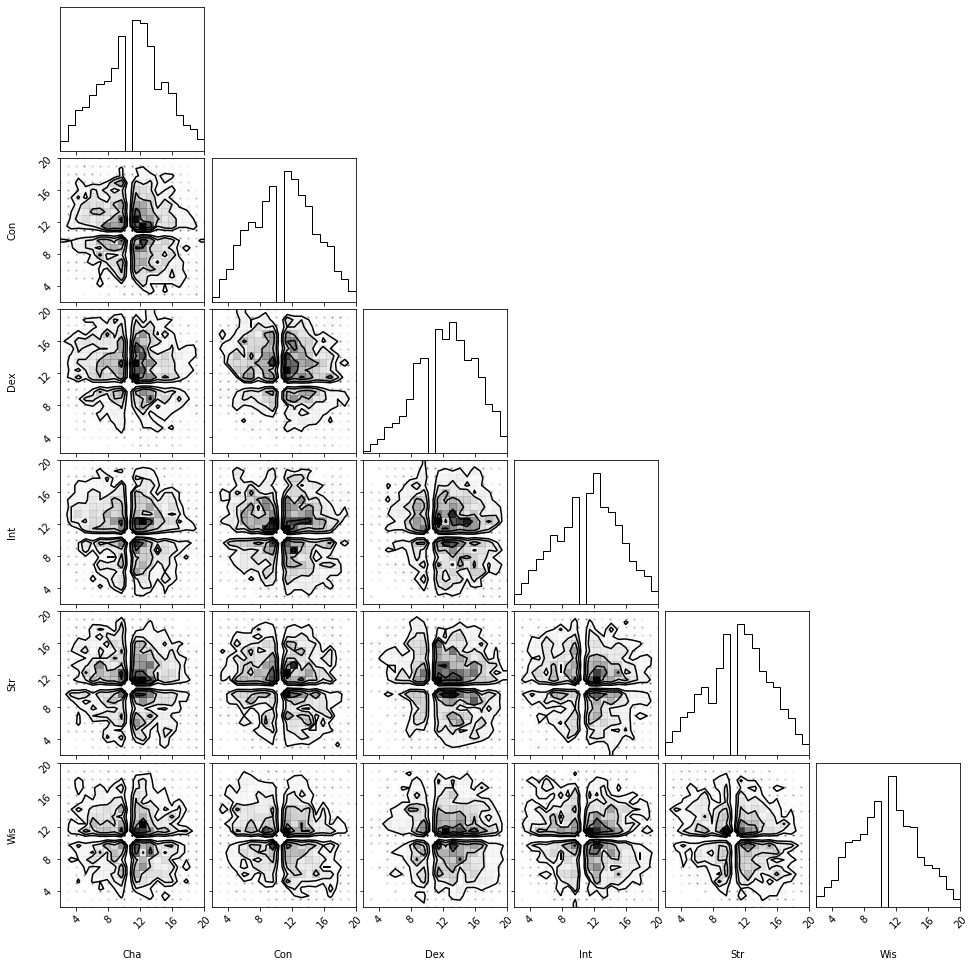

In [124]:
corner.corner(stats[fail_idxs,:], labels = stat_labels);

Based on just looking at these two corner plots side by side, it looks to me like:
* High Dex is overrepresented in failures, and high Int is slightly overrepresented in failures.
* High Cha, Con, Str, and Wis are overrepresented in successes.
* There is no noticeable interaction between stats.

From this super-preliminary look, I would say I'd try to get my Str and Cha up to around 10 (+4 str, +6 cha).

# (Roughly) Quantifying Stat Contributions

Based on what I've seen so far, I'm going to assume that stats contribute independently to success. For each statistic, how likely is success given each possible stat value? This is easy to tabulate. In each of these plots, I've put red squares around my current stats.

4827.0


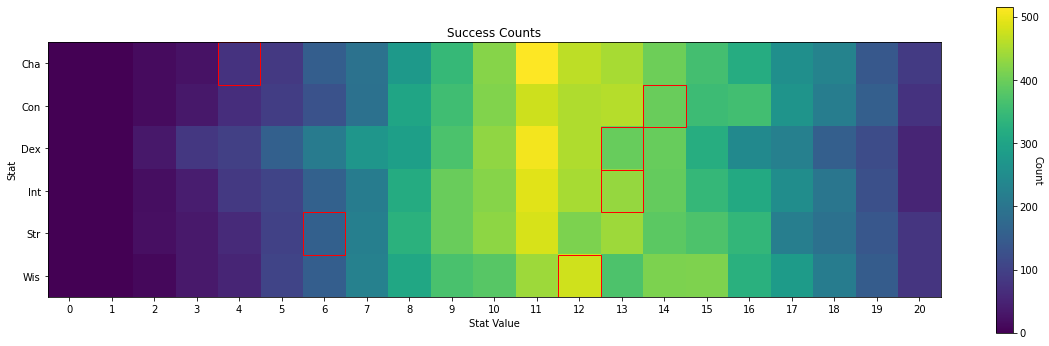

In [125]:
success_counts = np.array([[sum([1 for i in range(len(results)) if (stats[i,stat_idx] == stat_val and results[i] == 1)]) for stat_val in range(21)] for stat_idx in range(6)])
fig, ax = plt.subplots(figsize = (20,6))
img = ax.imshow(success_counts)
plt.title("Success Counts")
plt.ylabel("Stat")
plt.xlabel("Stat Value")
ax.set_yticks(np.arange(6))
ax.set_yticklabels(stat_labels)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21))
cbar = ax.figure.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Count", rotation = -90)

mystats = [4, 14, 13, 13, 6, 12]
patches = [mpl.patches.Rectangle((mystats[i]-.5,i-.5), 1, 1, fill = False, edgecolor = "red") for i in range(6)]
_ = [ax.add_patch(p) for p in patches]

print(sum(sum(success_counts))/6)

2560.0


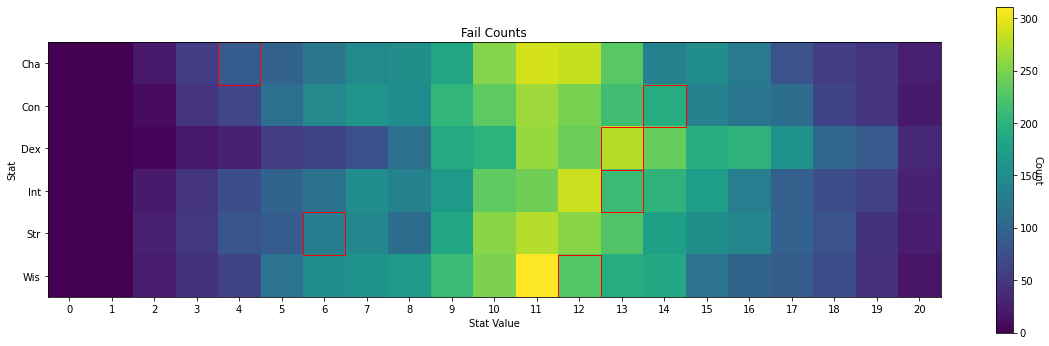

In [126]:
fail_counts = np.array([[sum([1 for i in range(len(results)) if (stats[i,stat_idx] == stat_val and results[i] == 0)]) for stat_val in range(21)] for stat_idx in range(6)])
fig, ax = plt.subplots(figsize = (20,6))
img = ax.imshow(fail_counts)
plt.title("Fail Counts")
plt.ylabel("Stat")
plt.xlabel("Stat Value")
ax.set_yticks(np.arange(6))
ax.set_yticklabels(stat_labels)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21))
cbar = ax.figure.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Count", rotation = -90)

patches = [mpl.patches.Rectangle((mystats[i]-.5,i-.5), 1, 1, fill = False, edgecolor = "red") for i in range(6)]
_ = [ax.add_patch(p) for p in patches]

print(sum(sum(fail_counts))/6)

And finally, the critical table:

<ipython-input-127-505ba45a4727>:1: RuntimeWarning: invalid value encountered in true_divide
  success_probabilities = np.divide(success_counts, fail_counts + success_counts)


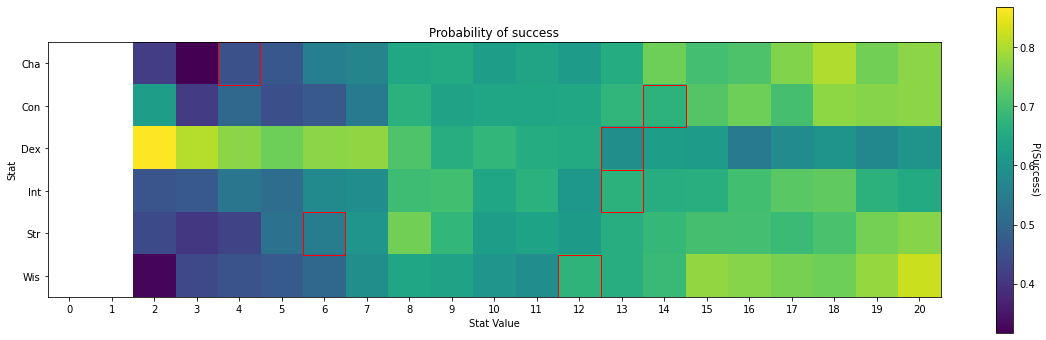

In [127]:
success_probabilities = np.divide(success_counts, fail_counts + success_counts)

fig, ax = plt.subplots(figsize = (20,6))
img = ax.imshow(success_probabilities)
plt.title("Probability of success")
plt.ylabel("Stat")
plt.xlabel("Stat Value")
ax.set_yticks(np.arange(6))
ax.set_yticklabels(stat_labels)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21))
cbar = ax.figure.colorbar(img, ax=ax)
cbar.ax.set_ylabel("P(Success)", rotation = -90)

patches = [mpl.patches.Rectangle((mystats[i]-.5,i-.5), 1, 1, fill = False, edgecolor = "red") for i in range(6)]
_ = [ax.add_patch(p) for p in patches]

It's a shame I can't ask the fairy to take away Dex.

Okay, so what should I put points into? What I really care about is "how much does the probability of success go up for each possible point improvement?". Gradients are harder to judge by eye than colors, so let's look at the diffs in probabilities as we move up in stats:

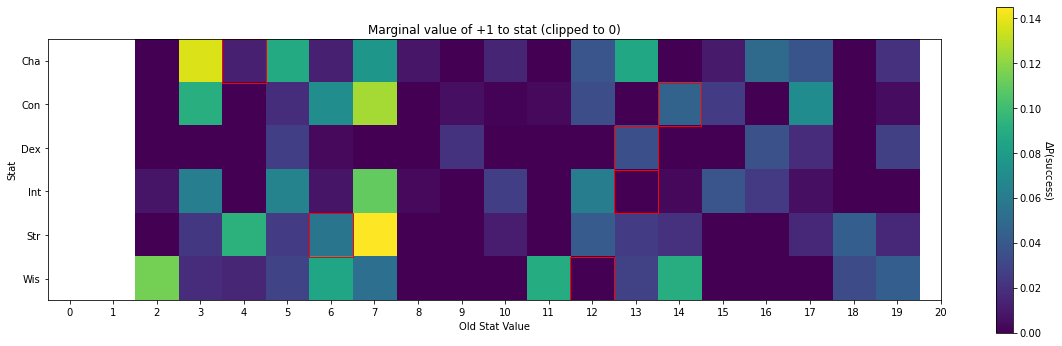

In [113]:
fig, ax = plt.subplots(figsize = (20,6))
img = ax.imshow(np.clip(np.diff(success_probabilities), 0, None))
plt.title("Marginal value of +1 to stat (clipped to 0)")
plt.ylabel("Stat")
plt.xlabel("Old Stat Value")
ax.set_yticks(np.arange(6))
ax.set_yticklabels(stat_labels)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(np.arange(21))
cbar = ax.figure.colorbar(img, ax=ax)
cbar.ax.set_ylabel(r"$\Delta$P(success)", rotation = -90, labelpad = 13)

patches = [mpl.patches.Rectangle((mystats[i]-.5,i-.5), 1, 1, fill = False, edgecolor = "red") for i in range(6)]
_ = [ax.add_patch(p) for p in patches]

Notice that the x-axis value is the *old* value of the stat before ticking up by one. If you're at a stat value with a yellow box on this chart, then you should increase the stat; if you're at a stat with a dark blue box on this chart, adding (1) to the stat either won't help or might actively hurt. (I originally plotted the full range of probability diffs, but that actually made it hard to see where stat increments flipped from being good to being harmful or neutral. If you want to see how badly a stat increase can *hurt*, take out the "np.clip" call on the second line.)

Using this last chart, I'll increase the values of each stat until they hit a solid wall of non-returns, starting with the stats that give highest marginal returns. By eye, I'm thinking:
* **+4 Cha**
* **+1 Str**
* **+2 Wis**
* **+3 Con**

I might go with something more like **+3 Cha** and **+1 Int** instead, on the basis that it looks like there's still returns to be had on intelligence and that I wouldn't be shocked at all if the apparently loss of gains between 14-16 Int is just noise. 